## Quick Links

[Cleaning Data](#Cleaning-Data)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Notes](#Notes:)  
[Standard Analysis](#Standard-Analysis)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Reward Leaning](#Reward-Learning)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Discriminability](#Discriminability)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Accuracy](#Accuracy)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Reaction Time](#Reaction-Time)   
[HDDM Analysis](#HDDM-Analysis)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Within model](#Within-model)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Between model](#Between-model)  

In [1]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
% matplotlib inline 
% reload_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: estimability

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: reshape2

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.

array(['afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans', 'estimability',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='<U12')

# Cleaning Data

Results in two csvs: **Data/prt_standard_first_session.csv** (which contains all of the "standard" data) & **Data/prt_all_trials_first_session.csv** (which contains all of the trial level data, merged with the relevant "standard" data).  
  
Can skip this section if you already have these files.

In [13]:
pwd

'/Users/mlm2/Work/Expts/EMBARC'

In [14]:
ls

APS/           Data/          Old_Notebooks/ Papers/
Analysis/      Misc/          PRT.ipynb


In [15]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [16]:
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/' + state + '/'
    temp_dir = base_dir + abrev + 'Temp/'
    old_files = base_dir + 'embarc_CU_' + abrev + '0*/done/sigdet_output*out'
    flist = !ls {old_files}
    
    !mkdir {temp_dir}
    
    for old_fname in flist:
        if abrev != 'CU':
            sub = old_fname.split('_')[2]
        else:
            sub = old_fname.split('_')[3]
        new_file = sub + '_out.txt'
        new_fname = temp_dir + new_file
        
        !cp {old_fname} {new_fname} # Done this way you don't get error messages when there's no old file

mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/New_York/CUTemp/: File exists
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file ... target_directory
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/: File exists


In [18]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'rich_due':line.split('\t')[7],
                             'lean_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('rich_key','Rich key:'),('lean_key','Lean key:'), ('subject','Subject ID:'), ('date','Date:'), 
                ('bias','Bias:'), ('rich_stim','Rich stimulus:'), ('lean_stim','Lean stimulus:')]:
        
        var_name, pattern = val
        df[var_name] = np.nan # Need some default values b/c some subjects have missing data        

        if var_name != 'date':
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        else:
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        
        with open(fname) as f:
            for line in f:
                var_match = var_def.search(line)
                if var_match:
                    result = var_match.group(1)
                    #checks if the subject ID is weird, prints it, and fixes it. For this data, all 3 digit sub ids
                    #are fixed by adding a 0 to the beginning. 
                    if var_name =='subject' and len(result) !=4:
                        print ('Check sub ID: ' + fname)
                        if len(result) == 3:
                            df[var_name]='0'+ result
                        if len(result) == 1:
                            df[var_name] ='000' + result
                    else:
                        df[var_name] = result

    return df

In [19]:
# Now you can just iterate over the files in each dir and use the code above to read each file into a ginorm df
today = datetime.datetime.today().strftime("%m_%d_%Y")

dfs = []
base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/'
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    state_dir = base_dir + state + '/' + abrev + 'Temp'
    flist = !ls {state_dir}
    
    for fname in flist:
        curr_path = state_dir + '/' + fname 
        statinfo = os.stat(curr_path) # checking for empty files b/c I found one . . .
        if statinfo.st_size == 0:
            #to make it compatible with 2 & 3
            print ('Empty file: '+ curr_path)
        else:
            df = SigDetParse(curr_path)
            df['site'] = abrev
            df['ProjectSpecificID'] = df['site'] + df['subject']
            dfs.append(df)
out = pd.concat(dfs)
out = out[['ProjectSpecificID','site','subject','date','bias','rich_stim','lean_stim','rich_key','lean_key',
           'trial','length','time','key_press','correct','did_reward','reward_due','rich_due','lean_due','outlier']]

Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0020MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0025MGBP2R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0027MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0039MGBP2R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0270MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/UM0001UMBP1R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0038MGBP3R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0198TXBP2R1_out.txt


In [20]:
# adding in the blocks
out['trial'] = pd.to_numeric(out['trial'])
out.loc[out['trial'] <= 100, 'block'] = 1
out.loc[out['trial'] > 100, 'block'] = 2

In [21]:
# Check that change fixed the wacky numbers, looks like it did
out.subject.unique()

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0018', '0020', '0021', '0025', '0026', '0027', '0028', '0030',
       '0032', '0039', '0040', '0051', '0060', '0064', '0066', '0069',
       '0070', '0074', '0076', '0081', '0086', '0101', '0104', '0106',
       '0112', '0116', '0117', '0120', '0125', '0126', '0135', '0137',
       '0138', '0142', '0152', '0155', '0157', '0158', '0161', '0164',
       '0168', '0172', '0180', '0182', '0185', '0187', '0198', '0202',
       '0206', '0207', '0209', '0213', '0214', '0218', '0220', '0222',
       '0228', '0230', '0231', '0238', '0239', '0242', '0243', '0246',
       '0248', '0251', '0252', '0253', '0256', '0257', '0259', '0261',
       '0269', '0270', '0009', '0011', '0012', '0014', '0015', '0016',
       '0017', '0023', '0024', '0029', '0031', '0033', '0034', '0035',
       '0036', '0037', '0038', '0042', '0046', '0047', '0048', '0049',
       '0050', '0052', '0056', '0058', '0065', '0073', '0077', '0078',
      

In [23]:
df_group = pd.read_csv('Data/groups.csv',encoding="latin-1")
df_compact = []
df_compact = df_group[['ProjectSpecificID', 'feasibility', 'shaps_total_dichotomous', 
                       'shaps_total_continuous', 'severity1', 'conmed_16', 'conmed_11', 'conmed_06', 'conmed_01', 'partic_age', 'partic_gender', 'masq2_29', 'hamd_09']]

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,104,109,113,117,118,119,122,123,127,133,134,135,136,138,141,142,219,221,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,250,251,252,253,258,260,262,264,266,268,276,280,283,285,287,290,293,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,336,338,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,392,396,408,410,411,417,418,419,421,422,423,460,462,464,466,468,470,472,474,476,478,480,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,590,800,801,812,813,814,823,861) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
# for all states extract the standard data and put into one file

df_stand = pd.DataFrame()
for state in ['Massachusetts', 'Michigan', 'New_York', 'Texas']:
    df_state = pd.DataFrame()
    statesum = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/embarc*/*txt'
    folders  = !ls -d {statesum}
    
    for filename in folders:
        if filename != 'embarc_MG_subj_PRTsess_.txt' and filename != 'embarc_NY_subj_PRTsess_.txt'and filename != 'embarc_NY_subj****************_PRTsess2_short.txt' and filename != 'embarc_TX_subj_PRTsess_.txt' and filename != 'embarc_UM_subj_PRTsess_.txt' and filename !='Note.txt':
            x = pd.read_csv(filename, delim_whitespace = True, dtype={'subject':str, 'PRT_QC_Status':str, 'session':str})
            if 'subject' in x.columns:
                x.subject = x.subject.str.zfill(4) #fixing weird IDs
                df_stand = pd.concat([x, df_stand])
                df_state = pd.concat([x, df_state])
        
    df_state['ProjectSpecificID'] = df_state['site'] + df_state['subject'] 
    df_state = df_state[pd.notnull(df_state['subject'])]
    df_state = df_state[df_state.subject != '****************'] #we don't care about this person
    df_state.loc[df_state['site'] == 'NY', 'site'] = 'CU'# it's NY in this file
    df_state.to_csv('standard_' + state + '_' + today + '.csv')

df_stand = df_stand[df_stand.subject != '****************']
df_stand = df_stand[pd.notnull(df_stand['subject'])]
df_stand.loc[df_stand['site'] == 'NY', 'site'] = 'CU'
df_stand['ProjectSpecificID'] = df_stand['site'] + df_stand['subject']

Outputs the final "standard" data file

In [25]:
df_group_comp = df_compact[pd.notnull(df_compact['feasibility'])] # only care where there is a val for feasibility
df_group_comp = df_group_comp.loc[df_group_comp['feasibility'] != 2] # don't care if it's 2
   
df_group_comp.loc[df_group_comp['feasibility'] == 1, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 3, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 5, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 4, 'feasibility'] = 'CTL'# make the feasibility clearer (and strs for HDDM)
    
df_stand_clean = df_stand.merge(df_group_comp, how='outer')# merge on the compact groups data
df_stand_clean.loc[df_stand_clean['ProjectSpecificID'] == 'MG0020', 'session'] = '1' #recode this presumed typo
df_stand_clean = df_stand_clean.loc[df_stand_clean['PRT_QC_Status'] == '1']
df_stand_clean = df_stand_clean[pd.notnull(df_stand_clean['feasibility'])]
df_firstsess = df_stand_clean.loc[df_stand_clean['session'] == '1']
df_firstsess['ID_date'] = df_firstsess['ProjectSpecificID'] + df_firstsess['date1']
df_firstsess = df_firstsess[df_firstsess.ID_date != 'MG002010_24_2012'] #for some reason the second date was listed first
df_firstsess = df_firstsess.drop_duplicates('ProjectSpecificID') # takes the first session listed for each participant
                                                               # we should try playing around with this for MA since our
                                                               # descriptives are slightly different from Christians
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0019'] 
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'UM0102']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'MG0026']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0047'] # based on Christian's data, remove 
                                                                               # these subjects 
# Comparing to Christian's list
df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)    
christian_list = df_christian[0].astype(str)

# are we missing anything?
for subject in christian_list:
    if subject in df_firstsess.ProjectSpecificID.unique():
        pass
    else:
        print('Missing from ours: '+ subject)

# do we have anything extra?
for subject in df_firstsess.ProjectSpecificID:
    if subject in christian_list.unique():
        pass
    else:
        print('Not included in Christians: ' + subject)
    
#save the first session standard file
df_firstsess.to_csv('Data/prt_standard_first_session.csv')

/Users/mlm2/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Outputs the final trial-level data

In [26]:
df_firstsess['date'] = df_firstsess['date1'].replace(to_replace = '_', value ='/', regex = True)
df_firstsess.date.replace(to_replace = '_', value ='/')
df_trial_merged = out.merge(df_firstsess, how = 'outer', on = ['ProjectSpecificID', 'date']) # FIX THE DATE FORMAT AND MERGE 
                                                                                    # ON DATE TOO
df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['ProjectSpecificID'])]

df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['feasibility'])]
# renaming time & correct; the hddm package requires specific column names
df_trial_merged.rename(columns={'time':'rt', 'correct': 'response', 'ProjectSpecificID': 'subj_idx'}, inplace = True)

# number of outlier trials and non-outlier trials for the FIRST session
print(df_trial_merged.outlier.value_counts())

# don't include the outlier trials
df_trial_merged = df_trial_merged[df_trial_merged.outlier == '0']
print(df_trial_merged.outlier.value_counts())

# don't include duplicates (a few people in multiple times)
df_trial_merged = df_trial_merged.drop_duplicates()
df_trial_merged['rt_num'] = pd.to_numeric(df_trial_merged['rt'])
df_trial_merged['response_num'] = pd.to_numeric(df_trial_merged['response'])
df_block1 = df_trial_merged[df_trial_merged['block'] == 1]
df_block2 = df_trial_merged[df_trial_merged['block'] == 2]

# THIS IS THE FILE TO USE FOR THE HDDM
df_trial_merged.to_csv('Data/prt_all_trials_first_session.csv')

0    59008
1      792
Name: outlier, dtype: int64
0    59008
Name: outlier, dtype: int64


## Notes:
#### Massachusetts:
MG0081 & MG0164 had two sessions labled '1.' Since both sessions were complete, the ones with the earlier dates were used. Christian included MG020, which was originally coded as only having a session two; this was probably a typo and I included it. After these corrections everything matched, except that Christian's list included MG0164 twice (so our n for MDDs is one less than his). 

Our descriptives look the same as Christian's after dropping MG0020's second session and using the one on 10/17. The way it was initially coded it was keeping the old one. 

#### New York: 
CU0017, CU0018, and CU0019 had two sessions labled '1.' Since both sessions were complete and had all data I just took the ones with the earlier dates. Christian also excluded CU0047, so I removed them from ours. It's unclear from the data why they were excluded. 

Our descriptives look the same as Christian's.
#### Michigan:
UM0012 & UM0017 had two sessions labled '1.' Since both sessions were complete I took the first of the two for each. UM0016 had three lines of the exact same session 1 data, so I only included the first line. Christian also excluded UM0102, so I removed them from ours. It's unclear from the data why they were excluded.

Our descriptives look the same as Christian's except our MDD n is 51 and his is 52. I would guess that UM0102 was not included in the list of subIDs that were included, but was included when doing the descriptives. We should decide whether or not to keep this person. 
#### Texas:
Everything lined up with no alterations!

Our descriptives look the same as Christian's.

# Standard Analysis

load in the csvs...

In [31]:
df_standard = pd.read_csv('Data/prt_standard_first_session.csv')
df_trial = pd.read_csv('Data/prt_all_trials_first_session.csv')

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# we need to trim df_trial down or else r2py will freak out...
df_trial = df_trial[['subj_idx', 'site_x', 'trial', 'length', 'rt', 'response', 'outlier', 'block','feasibility', 'partic_age', 'partic_gender', 'shaps_total_dichotomous', 'shaps_total_continuous']]
df_trial.to_csv('Data/prt_trial_compact.csv')

# Participant Characteristics

## Age

In [19]:
sp.stats.ttest_ind(df_standard[(df_standard.feasibility == 'MDD')]['partic_age'],
                   df_standard[(df_standard.feasibility == 'CTL')]['partic_age'])

Ttest_indResult(statistic=-0.18525781242833575, pvalue=0.85315543903493929)

In [20]:
df_standard[(df_standard.feasibility == 'MDD')]['partic_age'].describe()

count    258.000000
mean      36.806202
std       13.285595
min       18.000000
25%       25.000000
50%       33.000000
75%       47.000000
max       65.000000
Name: partic_age, dtype: float64

In [21]:
df_standard[(df_standard.feasibility == 'CTL')]['partic_age'].describe()

count    36.000000
mean     37.250000
std      14.713211
min      18.000000
25%      25.000000
50%      32.500000
75%      51.000000
max      65.000000
Name: partic_age, dtype: float64

## Gender

In [27]:
print (df_standard.groupby('feasibility')['partic_gender'].value_counts())

feasibility  partic_gender
CTL          Female            21
             Male              15
MDD          Female           172
             Male              86
Name: partic_gender, dtype: int64


In [29]:
obs = np.array([[21,15],[172,86]])
chi2, p, dof, expected = sp.stats.chi2_contingency(obs,correction=False)
print ("Chi-square on Gender: chi-square = " + "{:.2f}".format(chi2) + "; df = " + "{:.2f}".format(dof) + \
"; p = " + "{:.2f}".format(p))

Chi-square on Gender: chi-square = 0.97; df = 1.00; p = 0.32


## Reward Learning

Group X Site ANOVA

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
            Effect     df  MSE    F p.value
1      feasibility 1, 286 0.04 0.31     .58
2             site 3, 286 0.04 0.56     .64
3 feasibility:site 3, 286 0.04 1.25     .29


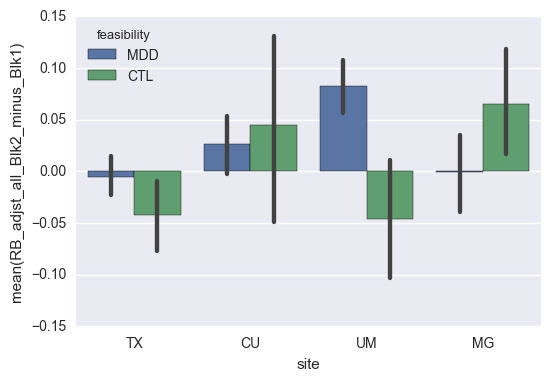

In [7]:
reward_learning_plot = sns.barplot(y='RB_adjst_all_Blk2_minus_Blk1', x = 'site', 
                                   data = df_standard, hue = 'feasibility', ci=68)
%Rpush df_standard
%R reward_learning_anova <- aov_ez("ProjectSpecificID", dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between = c("feasibility","site"),anova_table=list(correction="none", es = "none"))
%R print (reward_learning_anova)

Group X Site ANCOVA (discriminability)

In [36]:
%R reward_learning_ancova <- aov_ez("ProjectSpecificID",dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between=c("feasibility", "site"),covariate = "dis_adjst_all1_Total",factorize = FALSE,anova_table=list(correction="none", es = "none"))
%R print(reward_learning_ancova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
                Effect     df  MSE    F p.value
1          feasibility 1, 285 0.04 0.27     .60
2                 site 3, 285 0.04 0.57     .63
3 dis_adjst_all1_Total 1, 285 0.04 0.08     .78
4     feasibility:site 3, 285 0.04 1.25     .29


In [18]:
%Rpush df_standard
%R reward_learning_ancova_age_gender <- aov_ez("ProjectSpecificID",dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between=c("feasibility", "site"),covariate = c("partic_gender","dis_adjst_all1_Total","partic_age"),factorize = FALSE,anova_table=list(correction="none", es = "none"))
%R print(reward_learning_ancova_age_gender)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
                Effect     df  MSE    F p.value
1          feasibility 1, 283 0.04 0.23     .63
2                 site 3, 283 0.04 0.54     .66
3        partic_gender 1, 283 0.04 0.13     .72
4 dis_adjst_all1_Total 1, 283 0.04 0.12     .73
5           partic_age 1, 283 0.04 0.25     .62
6     feasibility:site 3, 283 0.04 1.22     .30


Correlating with Shaps


	Pearson's product-moment correlation

data:  df_standard_mdd$shaps_total_continuous and df_standard_mdd$RB_adjst_all_Blk2_minus_Blk1
t = 0.37458, df = 255, p-value = 0.7083
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.09919653  0.14539656
sample estimates:
       cor 
0.02345095 



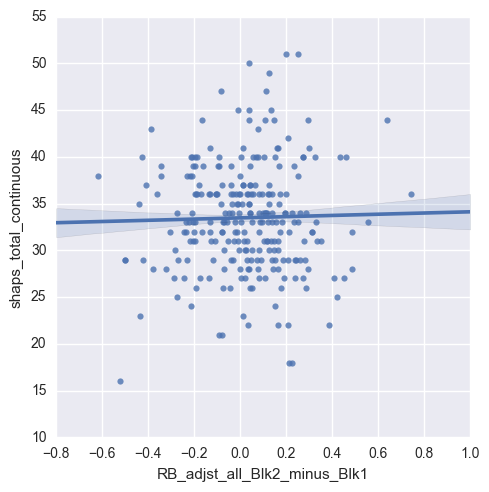

In [38]:
df_standard_mdd = df_standard.loc[df_standard['feasibility'] == 'MDD'] # just looking at the MDDs here
%Rpush df_standard_mdd
%R reward_learning_shaps <- cor.test(df_standard_mdd$shaps_total_continuous,df_standard_mdd$RB_adjst_all_Blk2_minus_Blk1,method="pearson")
%R print (reward_learning_shaps) 
reward_learning_shaps = sns.lmplot(y='shaps_total_continuous', x = 'RB_adjst_all_Blk2_minus_Blk1', data=df_standard_mdd,ci=68)

## Discriminability

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: dis_adjst_all1_Total
            Effect     df  MSE      F p.value
1      feasibility 1, 286 0.06 3.66 +     .06
2             site 3, 286 0.06   1.58     .19
3 feasibility:site 3, 286 0.06   0.09     .97


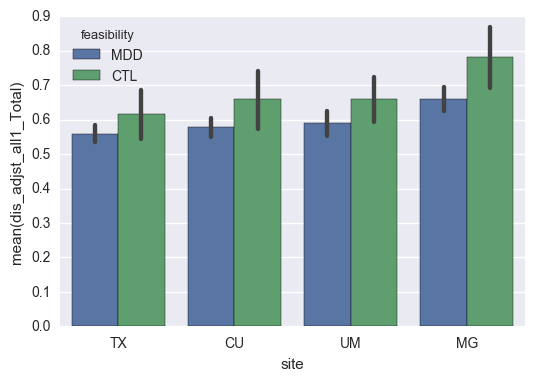

In [8]:
disc_plot = sns.barplot(y='dis_adjst_all1_Total', x = 'site', hue = 'feasibility', data=df_standard, ci=68)
%R disc_anova <- aov_ez("ProjectSpecificID",dv = "dis_adjst_all1_Total",data = df_standard,between=c("feasibility", "site"),anova_table=list(correction="none", es = "none"))
%R print(disc_anova)

## Accuracy

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: response
                            Effect     df  MSE         F p.value
1                      feasibility 1, 286 0.03    4.48 *     .04
2                           site_x 3, 286 0.03      1.43     .23
3               feasibility:site_x 3, 286 0.03      0.04     .99
4                            block 1, 286 0.00      1.40     .24
5                feasibility:block 1, 286 0.00      0.26     .61
6                     site_x:block 3, 286 0.00      0.10     .96
7         feasibility:site_x:block 3, 286 0.00      0.80     .49
8                           length 1, 286 0.01 49.56 ***  <.0001
9               feasibility:length 1, 286 0.01      0.00     .98
10                   site_x:length 3, 286 0.01      1.51     .21
11       feasibility:site_x:length 3, 286 0.01      0.65     .59
12                    block:length 1, 286 0.01      1.17     .28
13        feasibility:block:length 1, 286 0.01      0.12     .73
14             site_x:block:length 3, 286 0

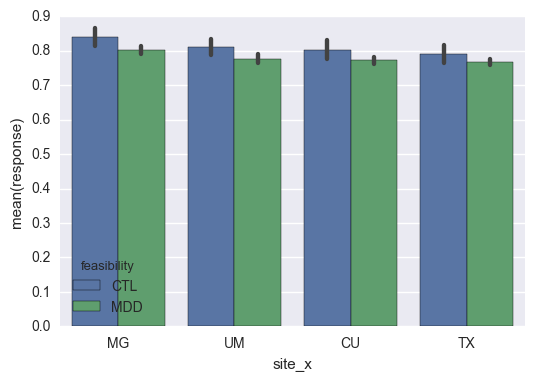

In [10]:
acc_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%Rpush df_trial
%R acc_anova <- aov_ez("subj_idx",dv = "response",data = df_trial ,between=c("feasibility", "site_x"),within=c("block","length"),anova_table=list(correction="none", es = "none"))
%R print(acc_anova)

**Adding age and gender as covariates**

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Converting to factor: partic_age

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x, partic_age, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: response
                            Effect      df  MSE         F p.value
1                      feasibility  1, 239 0.03    3.80 +     .05
2                           site_x  3, 239 0.03    2.16 +     .09
3                       partic_age 46, 239 0.03      0.84     .76
4                    partic_gender  1, 239 0.03      0.91     .34
5               feasibility:site_x  3, 239 0.03      0.17     .92
6                            block  1, 239 0.00      0.23     .63
7                feasibility:block  1, 239 0.00      2.10     .15
8                     site_x:block  3, 239 0.00      0.69     .56
9                 partic_age:block 46, 239 0.00      1.09     .33
10             partic_gender:block  1, 239 0.00      2.19     .14
11        feasibility:site_x:block  3, 239 0.00      1.97     .12
12                          length  1, 239 0.01 32.08 ***  <.0001
13              feasibility:length  1, 239 0.01      0.02     .88
14                   site_x:l

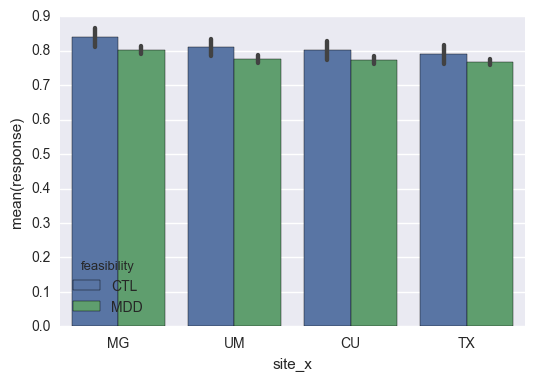

In [33]:
acc_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%Rpush df_trial
%R acc_anova <- aov_ez("subj_idx",dv = "response",data = df_trial ,between=c("feasibility", "site_x"),within=c("block","length"),covariate=c("partic_age","partic_gender"),anova_table=list(correction="none", es = "none"))
%R print(acc_anova)

## Reaction Time

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: rt
                            Effect     df      MSE         F p.value
1                      feasibility 1, 286 59264.28    5.54 *     .02
2                           site_x 3, 286 59264.28      0.42     .74
3               feasibility:site_x 3, 286 59264.28      1.41     .24
4                            block 1, 286  3540.32      0.72     .40
5                feasibility:block 1, 286  3540.32      0.76     .38
6                     site_x:block 3, 286  3540.32      0.66     .58
7         feasibility:site_x:block 3, 286  3540.32      0.18     .91
8                           length 1, 286  1566.47 43.86 ***  <.0001
9               feasibility:length 1, 286  1566.47      0.01     .92
10                   site_x:length 3, 286  1566.47      0.32     .81
11       feasibility:site_x:length 3, 286  1566.47      0.46     .71
12                    block:length 1, 286   794.17  10.68 **    .001
13        feasibility:block:length 1, 286   794.17      0.08  

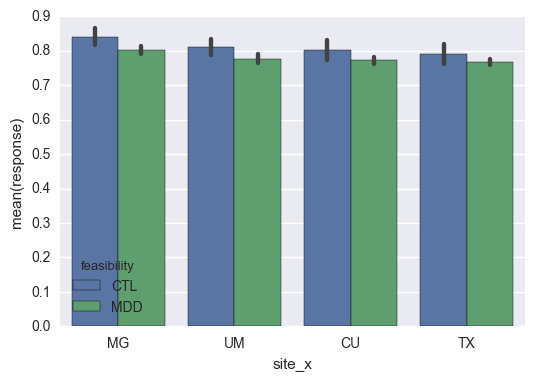

In [12]:
rt_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%R rt_anova <- aov_ez("subj_idx","rt",data = df_trial,between=c("feasibility", "site_x"),within=c("block","length"),anova_table=list(correction="none", es = "none"))
%R print (rt_anova)

**Adding age and gender as covariates**

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Converting to factor: partic_age

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x, partic_age, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: rt
                            Effect      df      MSE         F p.value
1                      feasibility  1, 239 51311.43    6.33 *     .01
2                           site_x  3, 239 51311.43      0.87     .46
3                       partic_age 46, 239 51311.43  1.98 ***   .0005
4                    partic_gender  1, 239 51311.43      0.42     .52
5               feasibility:site_x  3, 239 51311.43      0.66     .58
6                            block  1, 239  3172.16      0.00     .96
7                feasibility:block  1, 239  3172.16      1.13     .29
8                     site_x:block  3, 239  3172.16    2.16 +     .09
9                 partic_age:block 46, 239  3172.16   1.74 **    .004
10             partic_gender:block  1, 239  3172.16      1.02     .31
11        feasibility:site_x:block  3, 239  3172.16      0.66     .57
12                          length  1, 239  1432.20 35.16 ***  <.0001
13              feasibility:length  1, 239  1432.

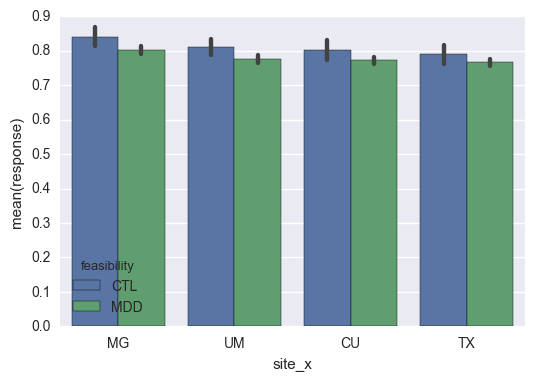

In [34]:
rt_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%R rt_anova <- aov_ez("subj_idx","rt",data = df_trial,between=c("feasibility", "site_x"),within=c("block","length"),covariate=c("partic_age","partic_gender"),anova_table=list(correction="none", es = "none"))
%R print (rt_anova)

# HDDM Analysis

Simple model that doesn't take within-subject factors into consideration; this gets smoother with larger sampling, I just wanted to make sure it was still working

In [17]:
all_data = hddm.load_csv('Data/prt_trial_compact.csv')
all_data['rt'] = all_data['rt'] / 1000 # convert to seconds

In [18]:
m_general = hddm.HDDM(all_data, depends_on={'v': 'feasibility', 'a': 'feasibility', 't':'feasibility'})
m_general.find_starting_values()
m_general.sample(1000, burn=100)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 342.7 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


P_v(MDD > CTL) =  0.0
P_v(CTL > MDD) =  1.0


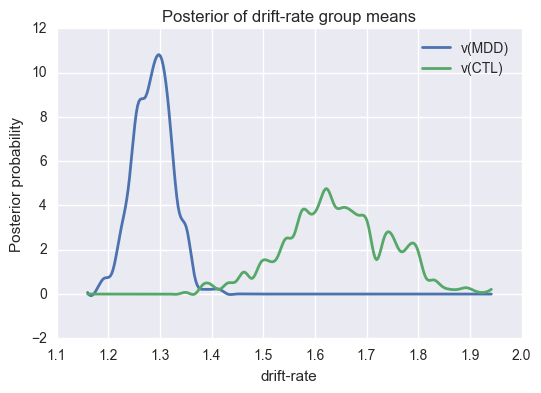

In [19]:
v_MDD, v_CTL = m_general.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('ctl_mdd_drift_rate_more_samples.pdf')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_a(MDD > CTL) =  0.994444444444
P_a(CTL > MDD) =  0.00555555555556


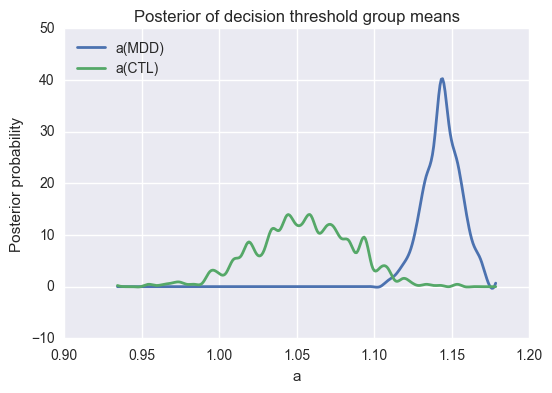

In [20]:
a_MDD, a_CTL = m_general.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

P_t(MDD > CTL) =  0.224444444444
P_t(CTL > MDD) =  0.775555555556


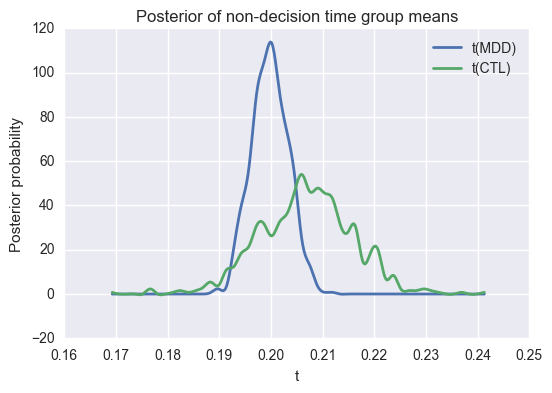

In [21]:
t_MDD, t_CTL = m_general.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CTL])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_t(MDD > CTL) = ", (t_MDD.trace() > t_CTL.trace()).mean())
print ("P_t(CTL > MDD) = ", (t_CTL.trace() > t_MDD.trace()).mean())

In [5]:
full_model = hddm.load_csv('Data/prt_trial_compact.csv')
full_model['rt'] = full_model['rt'] / 1000
del full_model['Unnamed: 0']
del full_model['outlier']
m_full_model = hddm.HDDMRegressor(full_model, ['v ~ feasibility', 'a ~ feasibility'])
m_full_model.sample(1000, burn=100)

Adding these covariates:
['v_Intercept', 'v_feasibility[T.MDD]']
Adding these covariates:
['a_Intercept', 'a_feasibility[T.MDD]']


/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 8406.8 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [11]:
v_MDD = m_full_model.nodes_db.node[['v(MDD)']]
hddm.analyze.plot_posterior_nodes([v_MDD])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

AttributeError: 'Series' object has no attribute 'trace'

In [37]:
full_model = hddm.load_csv('Data/prt_trial_compact.csv')
full_model['rt'] = full_model['rt'] / 1000
del full_model['Unnamed: 0']
del full_model['outlier']
m_full_model = hddm.HDDMRegressor(full_model, ['v ~ 0 + feasibilty*length*block', 'a ~ 0 + feasibility*length*block'])
m_full_model.sample(1000, burn=100)

,subj_idx,site_x,trial,length,rt,response,block,feasibility,shaps_total_dichotomous,shaps_total_continuous
0,MG0006,MG,1,short,0.704,0,1.0,CTL,2.0,28.0
1,MG0006,MG,2,long,0.414,1,1.0,CTL,2.0,28.0
2,MG0006,MG,3,short,0.456,1,1.0,CTL,2.0,28.0
3,MG0006,MG,4,long,0.416,1,1.0,CTL,2.0,28.0
4,MG0006,MG,5,short,0.490,0,1.0,CTL,2.0,28.0
5,MG0006,MG,6,short,0.481,1,1.0,CTL,2.0,28.0
6,MG0006,MG,7,short,0.553,1,1.0,CTL,2.0,28.0
7,MG0006,MG,8,long,0.509,1,1.0,CTL,2.0,28.0
8,MG0006,MG,9,short,0.483,0,1.0,CTL,2.0,28.0
9,MG0006,MG,10,short,0.378,1,1.0,CTL,2.0,28.0
